In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.models import Sequential, Model
from keras.layers import Activation, Flatten, Dense,  BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from matplotlib.pyplot import imshow
from tensorflow.keras.utils import load_img, img_to_array 
from sklearn.model_selection import train_test_split
from keras.applications.resnet import ResNet101
from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import load_model
import shutil
import glob
import os
from PIL import Image


In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
No_tumor = '/content/drive/MyDrive/classification/classification/picture/no'
Have_tumor = '/content/drive/MyDrive/classification/classification/picture/yes'
Main_location = '/content/drive/MyDrive/classification/classification/picture'

In [ ]:
list_brain_image=[No_tumor, Have_tumor]
classes=['No_tumor', 'Have_tumor']
images_location=[]
labels=[]


for i,j in zip(list_brain_image, classes):
    list_of_file=os.listdir(i)
    for f in list_of_file:
        image_location=os.path.join (i,f)
        images_location.append(image_location)
        labels.append(j)

 

print ('Number of image: ', len(images_location), '   Number of image has label: ', len(labels))


Number of image:  253    Number of image has label:  253


In [ ]:
Location=pd.Series(images_location, name='location')
Label=pd.Series(labels, name='labels')

#connect the path of brain image and their label (Have_tumor , No_tumor)
connect_image_label=pd.concat([Location,Label], axis=1)

#draw the table to visualize 
connect_image_label=pd.DataFrame(np.array(connect_image_label).reshape(253,2), columns = ['location', 'labels'])
connect_image_label.head()

,location,labels
0,/content/drive/MyDrive/classification/classifi...,No_tumor
1,/content/drive/MyDrive/classification/classifi...,No_tumor
2,/content/drive/MyDrive/classification/classifi...,No_tumor
3,/content/drive/MyDrive/classification/classifi...,No_tumor
4,/content/drive/MyDrive/classification/classifi...,No_tumor


In [ ]:
print(connect_image_label['labels'].value_counts())

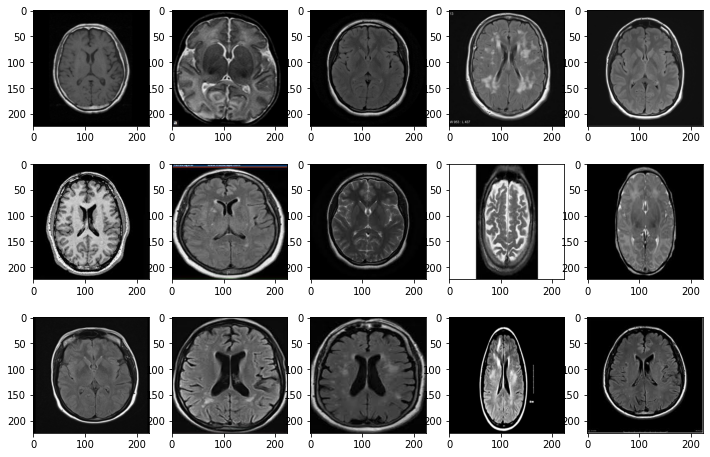

In [ ]:
data =[]

for path in images_location:
  img = Image.open(path)
  img = img.resize((224,224))
  img = np.array(img)
  data.append(img)

plt.figure(figsize=(12,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(data[i], cmap="gray")

    
plt.show()

In [ ]:
#split the data to 3 part : train dataset, test dataset, validation data
train, test = train_test_split(connect_image_label, train_size=0.80, random_state=3)
train, valid = train_test_split(train, train_size=0.95, random_state=3)

print(f"train set: {train.shape}")
print(f"test set: {test.shape}")
print(f"validation set: {valid.shape}")


train set: (191, 2)
test set: (51, 2)
validation set: (11, 2)


In [ ]:
#rescale image from rgb (0-255) to (0,1)
train_image_datagen = ImageDataGenerator(rescale = 1./255.)
test_image_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [ ]:
train_datagen = train_image_datagen.flow_from_dataframe(dataframe = train,
                                              x_col = 'location', y_col ='labels',
                                              target_size = (224,224), batch_size = 15, 
                                              class_mode = 'binary', shuffle = True)

validation_datagen = train_image_datagen.flow_from_dataframe(valid, 
                                            target_size=(224,224), x_col = 'location', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 15, shuffle=True)

test_datagen = test_image_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'location', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 15, shuffle = False)

Found 191 validated image filenames belonging to 2 classes.
Found 11 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


(15, 224, 224, 3)


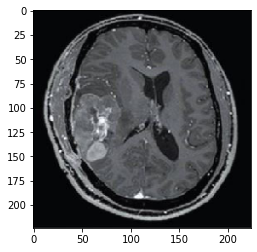

(15, 224, 224, 3)


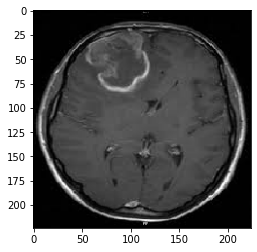

(15, 224, 224, 3)


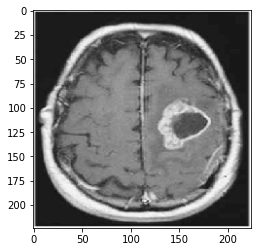

(15, 224, 224, 3)


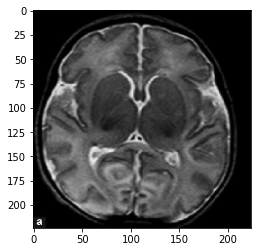

(15, 224, 224, 3)


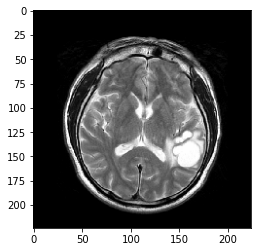

In [ ]:
for _ in range(5):
    img, label = train_datagen.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

In [ ]:
train_datagen.class_indices

{'Have_tumor': 0, 'No_tumor': 1}

In [ ]:
base_model= VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
 

model = Sequential()
model.add(base_model)
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dense_8 (Dense)             (None, 7, 7, 128)         65664     
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_4 (Flatten)         (None, 6272)              0         
                                                                 
 dense_9 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 14,786,625
Trainable params: 14,786,625
Non-trainable params: 0
___________________________________________

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer='adam', metrics=['accuracy'])


history = model.fit(train_datagen, validation_data = validation_datagen, epochs = 20)

Epoch 1/20
13/13 [==============================] - 370s 28s/step - loss: 25.3679 - accuracy: 0.5916 - val_loss: 0.6947 - val_accuracy: 0.5455
Epoch 2/20
13/13 [==============================] - 369s 28s/step - loss: 0.7315 - accuracy: 0.5288 - val_loss: 0.6857 - val_accuracy: 0.4545
Epoch 3/20
13/13 [==============================] - 368s 28s/step - loss: 0.7064 - accuracy: 0.5759 - val_loss: 0.7434 - val_accuracy: 0.4545
Epoch 4/20
13/13 [==============================] - 367s 28s/step - loss: 0.6869 - accuracy: 0.6230 - val_loss: 0.7114 - val_accuracy: 0.4545
Epoch 5/20
13/13 [==============================] - 371s 28s/step - loss: 0.6520 - accuracy: 0.6440 - val_loss: 0.7144 - val_accuracy: 0.4545
Epoch 6/20
13/13 [==============================] - 370s 28s/step - loss: 0.6490 - accuracy: 0.6597 - val_loss: 0.6477 - val_accuracy: 0.5455
Epoch 7/20
13/13 [==============================] - 374s 29s/step - loss: 0.5849 - accuracy: 0.7173 - val_loss: 0.4283 - val_accuracy: 0.9091
Epoch

In [ ]:

model.evaluate(test_datagen)

4/4 [==============================] - 28s 7s/step - loss: 0.5503 - accuracy: 0.7255


[0.5502870678901672, 0.7254902124404907]

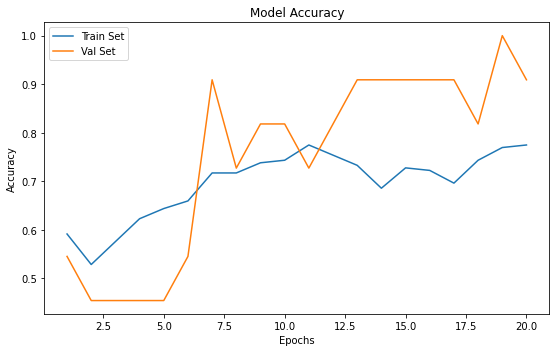

In [ ]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy, label='Train Set')
plt.plot(epochs_range, validation_accuracy, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')



plt.tight_layout()
plt.show()

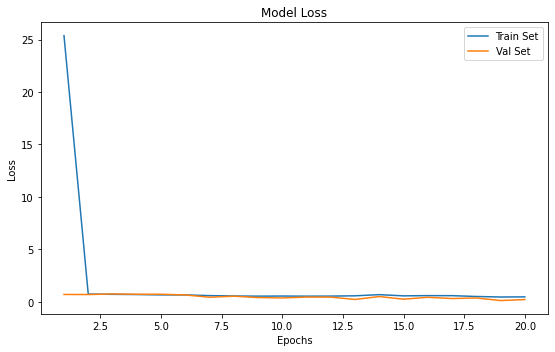

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, validation_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
def tumor_result(number):
    if number < 0.5:
        return 'Its a Tumor'
    else:
        return 'No, Its not a tumor'

In [ ]:
model.save('/content/drive/MyDrive/classification /picture/VGG16_model_1.h5') 
del model  

In [ ]:
model = load_model('/content/drive/MyDrive/classification /picture/VGG16_model_1.h5')

In [ ]:
model.evaluate(test_datagen)

In [ ]:
!pip install visualkeras 
import visualkeras




visualkeras.layered_view(model, legend=True)  # font is optional!
visualkeras.layered_view(model).show() # display using your system viewer


visualkeras.layered_view(model)

(1, 224, 224, 3)
1/1 [==============================] - 1s 883ms/step


'No, Its not a tumor'

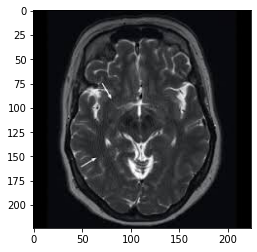

In [ ]:
img_path = '/content/drive/MyDrive/classification/classification/picture/no/3 no.jpg'
img = image.load_img(img_path, target_size=(224,224,3))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_batch = np.array(img_batch).astype('float32')/255
print(img_batch.shape)
plt.imshow(img)
res = model.predict(img_batch)
res
tumor_result(res)

(1, 224, 224, 3)
1/1 [==============================] - 1s 556ms/step


'Its a Tumor'

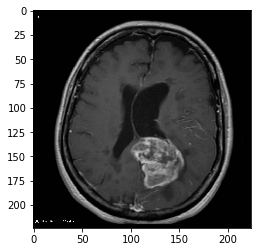

In [ ]:
img_path = '/content/drive/MyDrive/classification/classification/picture/yes/Y96.jpg'
img = image.load_img(img_path, target_size=(224,224,3))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_batch = np.array(img_batch).astype('float32')/255
print(img_batch.shape)
plt.imshow(img)
res = model.predict(img_batch)
tumor_result(res)


pre trained model 2

In [ ]:
model_MobileNetV2= MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False)
 

model_2 = Sequential()
model_2.add(model_MobileNetV2)
model_2.add(BatchNormalization())
model_2.add(Dense(128, activation = 'relu'))
model_2.add(Dropout(0.5))
model_2.add(Flatten())

model_2.add(Dense(1,activation='sigmoid'))
model_2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 batch_normalization_5 (Batc  (None, 7, 7, 1280)       5120      
 hNormalization)                                                 
                                                                 
 dense_22 (Dense)            (None, 7, 7, 128)         163968    
                                                                 
 dropout_11 (Dropout)        (None, 7, 7, 128)         0         
                                                                 
 flatten_11 (Flatten)        (None, 6272)              0         
                                                                 
 dense_23 (Dense)            (None, 1)               

In [ ]:
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer='adam', metrics=['accuracy'])


history = model_2.fit(train_datagen, validation_data = validation_datagen, epochs = 20)

Epoch 1/20
13/13 [==============================] - 46s 3s/step - loss: 0.9078 - accuracy: 0.7068 - val_loss: 0.4342 - val_accuracy: 0.7273
Epoch 2/20
13/13 [==============================] - 41s 3s/step - loss: 0.5816 - accuracy: 0.8063 - val_loss: 0.6195 - val_accuracy: 0.6364
Epoch 3/20
13/13 [==============================] - 39s 3s/step - loss: 0.2652 - accuracy: 0.9319 - val_loss: 0.4470 - val_accuracy: 0.8182
Epoch 4/20
13/13 [==============================] - 39s 3s/step - loss: 0.3249 - accuracy: 0.9215 - val_loss: 1.4024 - val_accuracy: 0.6364
Epoch 5/20
13/13 [==============================] - 42s 3s/step - loss: 0.2295 - accuracy: 0.9267 - val_loss: 0.1778 - val_accuracy: 1.0000
Epoch 6/20
13/13 [==============================] - 38s 3s/step - loss: 0.1846 - accuracy: 0.9424 - val_loss: 0.7911 - val_accuracy: 0.7273
Epoch 7/20
13/13 [==============================] - 38s 3s/step - loss: 0.2771 - accuracy: 0.9372 - val_loss: 3.6012 - val_accuracy: 0.4545
Epoch 8/20
13/13 [==

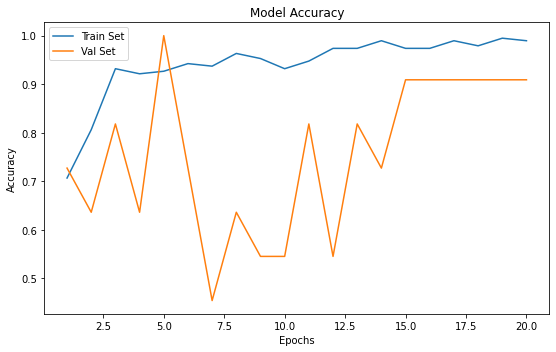

In [ ]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy, label='Train Set')
plt.plot(epochs_range, validation_accuracy, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')



plt.tight_layout()
plt.show()

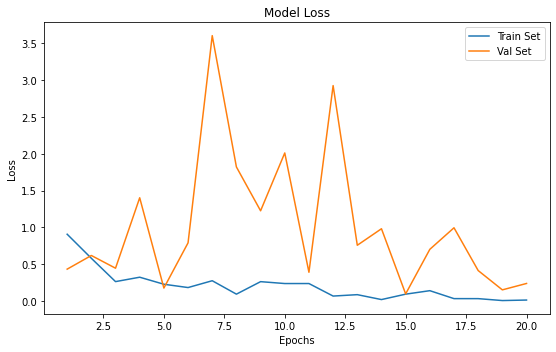

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, validation_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
model_2.save('/content/drive/MyDrive/classification/classification/picture/MobilenetV2_2_model.h5') 

In [ ]:
model_2 = load_model('/content/drive/MyDrive/classification/classification/picture/MobilenetV2_2_model.h5') 

(1, 224, 224, 3)
1/1 [==============================] - 1s 964ms/step


'Its a Tumor'

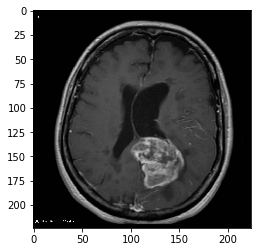

In [ ]:
img_path = '/content/drive/MyDrive/classification/classification/picture/yes/Y96.jpg'
img = image.load_img(img_path, target_size=(224,224,3))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_batch = np.array(img_batch).astype('float32')/255
print(img_batch.shape)
plt.imshow(img)
res = model_2.predict(img_batch)
tumor_result(res)


(1, 224, 224, 3)
1/1 [==============================] - 0s 151ms/step


'No, Its not a tumor'

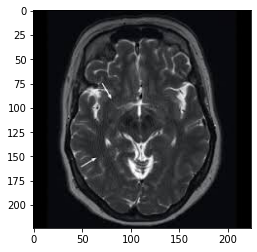

In [ ]:
img_path = '/content/drive/MyDrive/classification/classification/picture/no/3 no.jpg'
img = image.load_img(img_path, target_size=(224,224,3))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_batch = np.array(img_batch).astype('float32')/255
print(img_batch.shape)
plt.imshow(img)
res = model_2.predict(img_batch)
res
tumor_result(res)

In [ ]:
model_2.evaluate(test_datagen)

4/4 [==============================] - 3s 404ms/step - loss: 0.8308 - accuracy: 0.7843


[0.8308367133140564, 0.7843137383460999]